<a href="https://colab.research.google.com/github/efemeryczny/network_analysis/blob/main/stock_market_indices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
csv_files = ('/content/drive/MyDrive/Colab Notebooks/polish_stock_market')

In [8]:
import os
# Directory containing the CSV files
directory = '/content/drive/MyDrive/Colab Notebooks/polish_stock_market'

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]

# Initialize an empty DataFrame to store the merged data
merged_data = pd.DataFrame()

# Iterate over each CSV file and merge its contents
for file in csv_files:
    file_path = os.path.join(directory, file)
    data = pd.read_csv(file_path)
    merged_data = merged_data.append(data)

# Reset the index of the merged data
merged_data.reset_index(drop=True, inplace=True)

# Output the merged data
print(merged_data.head())

<ipython-input-8-bccff4cc65e8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data)
<ipython-input-8-bccff4cc65e8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data)
<ipython-input-8-bccff4cc65e8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data)
<ipython-input-8-bccff4cc65e8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data)
<ipython-input-8-bccff4cc65e8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inste

         Data  Otwarcie  Najwyzszy  Najnizszy  Zamkniecie    Wolumen Symbol  \
0  2012-12-14    48.521     50.396     48.521      49.662  3722524.0    NaN   
1  2012-12-17    48.969     50.152     48.969      49.948   253690.0    NaN   
2  2012-12-18    50.396     50.886     50.152      50.763   478372.0    NaN   
3  2012-12-19    50.886     51.008     50.763      50.926   192914.0    NaN   
4  2012-12-20    50.560     51.049     50.478      50.763    92960.0    NaN   

  Czas  
0  NaN  
1  NaN  
2  NaN  
3  NaN  
4  NaN  


<ipython-input-8-bccff4cc65e8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_data = merged_data.append(data)


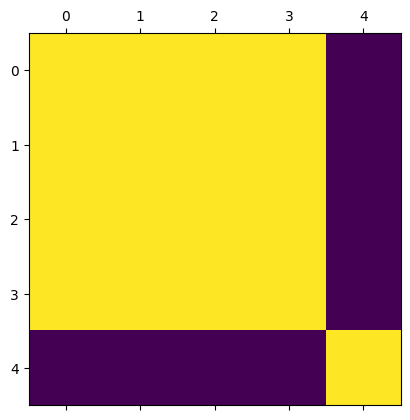

In [9]:
plt.matshow(merged_data.corr(numeric_only=True))

In [5]:
for file in csv_files:
  dane = pd.read_csv(csv_files + file, index_col = 'Data', engine = 'python')

  main_table = main_table.merge(right=dane,
                                how='inner',
                                left_index=True,
                                right_index=True,
                                copy=False,
                                suffixes=('','_'+file[:4])
                                )
  main_table.to_csv(csv_files + 'integrated_data.csv')

IsADirectoryError: ignored

In [ ]:
csv_files = {
    'djusbk': '/content/drive/MyDrive/Colab Notebooks/stock_market/DJUSBK.csv',
    'euro': '/content/drive/MyDrive/Colab Notebooks/stock_market/euro.csv',
    'wigbanki': '/content/drive/MyDrive/Colab Notebooks/stock_market/wigbanki.csv'
}

In [ ]:
wigbanki = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stock_market/wigbanki.csv')
wigbanki.rename(columns={'Zamkniecie': 'Close'}, inplace=True)
wigbanki

,Data,Otwarcie,Najwyzszy,Najnizszy,Close,Wolumen
0,1991-04-16,100.00,100.00,100.00,100.00,35.0
1,1991-04-23,96.77,96.77,96.77,96.77,630.0
2,1991-04-30,94.56,94.56,94.56,94.56,764.0
3,1991-05-14,93.96,93.96,93.96,93.96,1952.0
4,1991-05-21,96.61,96.61,96.61,96.61,1573.0
...,...,...,...,...,...,...
7580,2023-05-25,7131.93,7259.66,7077.07,7204.33,3355354.0
7581,2023-05-26,7223.53,7357.07,7197.84,7349.04,5152298.0
7582,2023-05-29,7374.96,7378.36,7286.70,7335.93,2116403.0
7583,2023-05-30,7289.84,7293.94,7177.40,7181.76,3155805.0


In [ ]:
djusbk = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stock_market/DJUSBK.csv')
djusbk.rename(columns={'Date':'Data'}, inplace=True)
djusbk

,Data,Open,High,Low,Close
0,05/30/2023,398.35,398.35,398.35,398.35
1,05/25/2023,394.85,394.85,394.85,394.85
2,05/24/2023,395.19,395.19,395.19,395.19
3,05/23/2023,400.74,400.74,400.74,400.74
4,05/22/2023,400.29,400.29,400.29,400.29
...,...,...,...,...,...
238,06/06/2022,496.13,496.13,496.13,496.13
239,06/03/2022,495.37,495.37,495.37,495.37
240,06/02/2022,502.14,502.14,502.14,502.14
241,06/01/2022,496.22,496.22,496.22,496.22


In [ ]:
euro = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stock_market/euro.csv')
euro.rename(columns={'Date':'Data'}, inplace=True)
euro

,Data,Open,High,Low,Close
0,05/31/2023,"7,371.48","7,371.48","7,371.48","7,371.48"
1,05/30/2023,"7,142.98","7,142.98","7,142.98","7,142.98"
2,05/29/2023,"6,984.22","6,984.22","6,984.22","6,984.22"
3,05/26/2023,"6,919.21","6,919.21","6,919.21","6,919.21"
4,05/25/2023,"7,004.93","7,004.93","7,004.93","7,004.93"
...,...,...,...,...,...
247,06/06/2022,"10,298.60","10,298.60","10,298.60","10,298.60"
248,06/03/2022,"10,650.10","10,650.10","10,650.10","10,650.10"
249,06/02/2022,"10,551.06","10,551.06","10,551.06","10,551.06"
250,06/01/2022,"10,557.07","10,557.07","10,557.07","10,557.07"


In [ ]:
stocks = pd.concat([wigbanki, euro, djusbk], axis=1)


In [ ]:
#craetes a correlation matrix
cor_matrix = stocks.iloc[:,1:].corr()
#shows the first 5 rows
cor_matrix.head()

<ipython-input-33-960795271398>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor_matrix = stocks.iloc[:,1:].corr()


,Otwarcie,Najwyzszy,Najnizszy,Close,Wolumen,Open,High,Low,Close
Otwarcie,1.000000,0.999869,0.999853,0.999704,0.494700,0.129302,0.129302,0.129302,0.129302
Najwyzszy,0.999869,1.000000,0.999793,0.999866,0.497992,0.129302,0.129302,0.129302,0.129302
Najnizszy,0.999853,0.999793,1.000000,0.999872,0.492358,0.129302,0.129302,0.129302,0.129302
Close,0.999704,0.999866,0.999872,1.000000,0.495669,0.129302,0.129302,0.129302,0.129302
Wolumen,0.494700,0.497992,0.492358,0.495669,1.000000,0.289623,0.289623,0.289623,0.289623


In [ ]:
#Crates graph using the data of the correlation matrix
G = nx.from_numpy_array(cor_matrix)

#relabels the nodes to match the  stocks names
G = nx.relabel_nodes(G,lambda x: stocks[x])

#shows the edges with their corresponding weights
G.edges(data=True)

EdgeDataView([('Otwarcie', 'Otwarcie', {'weight': 1.0}), ('Otwarcie', 'Najwyzszy', {'weight': 0.9998694877048867}), ('Otwarcie', 'Najnizszy', {'weight': 0.999853319032196}), ('Otwarcie', 'Close', {'weight': 0.12930234412258887}), ('Otwarcie', 'Wolumen', {'weight': 0.49469977096376444}), ('Otwarcie', 'Open', {'weight': 0.12930234412258887}), ('Otwarcie', 'High', {'weight': 0.12930234412258887}), ('Otwarcie', 'Low', {'weight': 0.12930234412258887}), ('Najwyzszy', 'Najwyzszy', {'weight': 1.0}), ('Najwyzszy', 'Najnizszy', {'weight': 0.9997927424902344}), ('Najwyzszy', 'Close', {'weight': 0.12930234412258887}), ('Najwyzszy', 'Wolumen', {'weight': 0.49799220628066715}), ('Najwyzszy', 'Open', {'weight': 0.12930234412258887}), ('Najwyzszy', 'High', {'weight': 0.12930234412258887}), ('Najwyzszy', 'Low', {'weight': 0.12930234412258887}), ('Najnizszy', 'Najnizszy', {'weight': 1.0}), ('Najnizszy', 'Close', {'weight': 0.12930234412258887}), ('Najnizszy', 'Wolumen', {'weight': 0.49235756957211546}),

TypeError: ignored

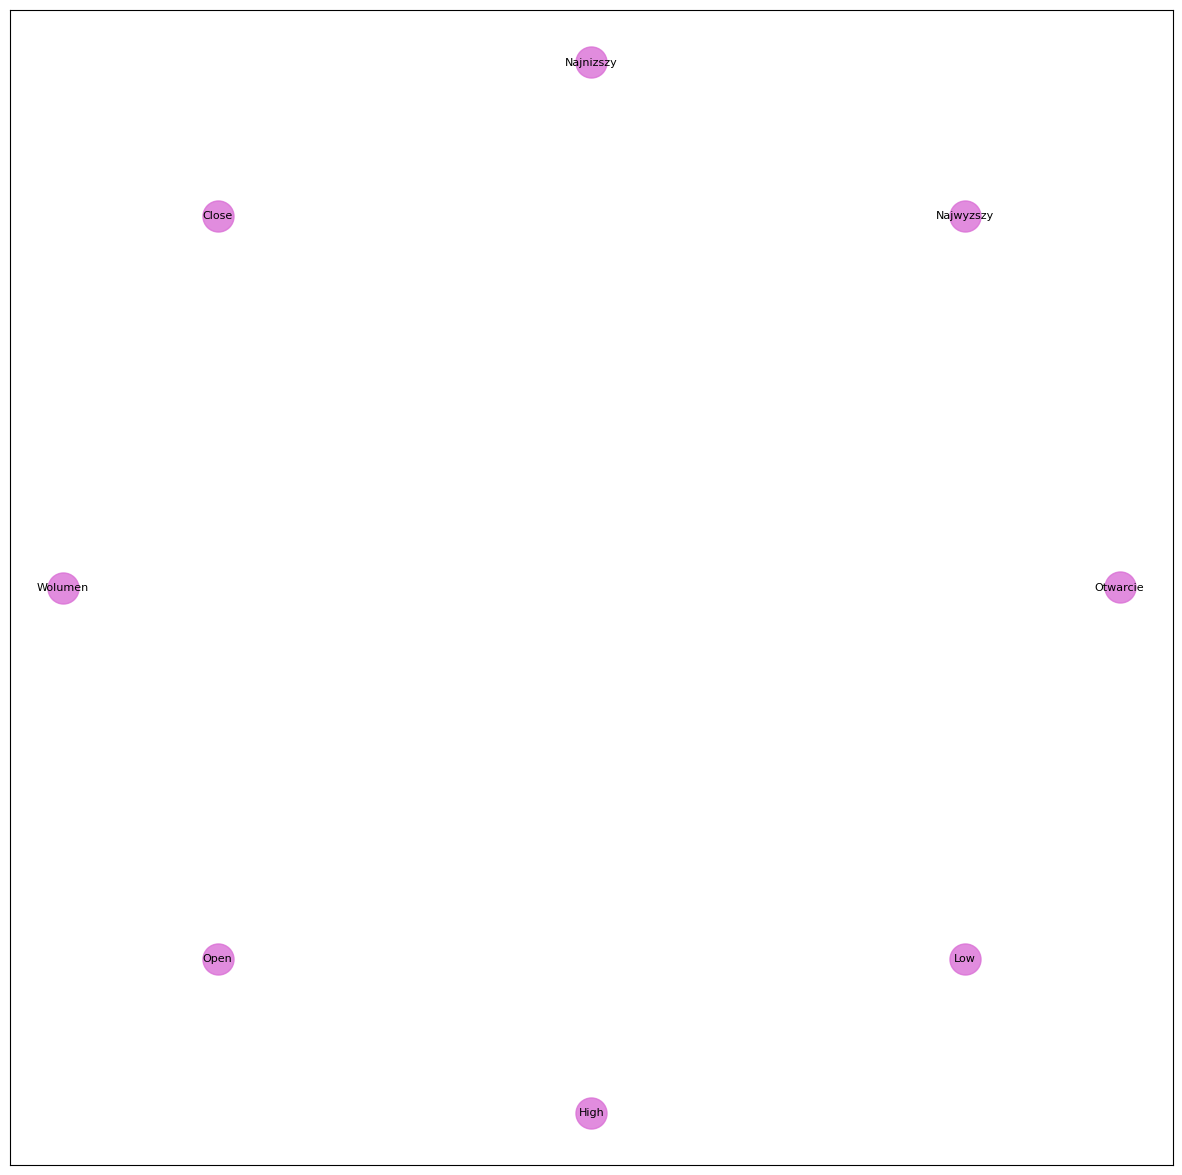

In [ ]:
#function to create and display networks from the correlatin matrix. 

def create_corr_network_1(G):
    #crates a list for edges and for the weights
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

    #positions
    positions=nx.circular_layout(G)
    
    #Figure size
    plt.figure(figsize=(15,15))

    #draws nodes
    nx.draw_networkx_nodes(G,positions,node_color='#DA70D6',
                           node_size=500,alpha=0.8)
    
    #Styling for labels
    nx.draw_networkx_labels(G, positions, font_size=8, 
                            font_family='sans-serif')
        
    #draws the edges
    nx.draw_networkx_edges(G, positions, edge_list=edges,style='solid')
    
    # displays the graph without axis
    plt.axis('off')
    #saves image
    plt.savefig("part1.png", format="PNG")
    plt.show() 

create_corr_network_1(G)

In [ ]:

#extracts the indices from the correlation matrix, which are the stocks
stocks = cor_matrix.index.values

#Changes from dataframe to matrix, so it is easier to create a graph with networkx
cor_matrix = np.asmatrix(cor_matrix)

Number of nodes: 3
Number of edges: 0
Average clustering coefficient: 0.0


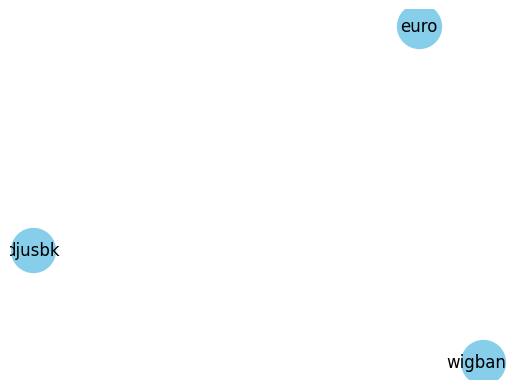

In [ ]:
# Merge the dataframes on 'Data' column to align the dates
merged_df = wigbanki[['Data', 'Close']].merge(djusbk[['Data', 'Close']], on='Data', how='inner')
merged_df = merged_df.merge(euro[['Data', 'Close']], on='Data', how='inner')

# Extract the aligned price series from the merged dataframe
wigbanki_prices = merged_df['Close_x'].values
djusbk_prices = merged_df['Close_y'].values
euro_prices = merged_df['Close'].values

# Store the data in a dictionary
index_data = {
    'wigbanki': wigbanki_prices,
    'djusbk': djusbk_prices,
    'euro': euro_prices
}

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for index in index_data:
    G.add_node(index)

# Calculate correlation matrix between indices
valid_indices = [index for index in index_data if len(index_data[index]) > 0]
corr_matrix = np.zeros((len(valid_indices), len(valid_indices)))

for i in range(len(valid_indices)):
    for j in range(i + 1, len(valid_indices)):
        index1 = valid_indices[i]
        index2 = valid_indices[j]
        prices1 = index_data[index1]
        prices2 = index_data[index2]
        common_dates = set(prices1.keys()).intersection(set(prices2.keys()))
        prices1_common = [prices1[date] for date in common_dates]
        prices2_common = [prices2[date] for date in common_dates]
        corr_value = np.corrcoef(prices1_common, prices2_common)[0, 1]
        corr_matrix[i, j] = corr_value
        corr_matrix[j, i] = corr_value

# Add edges to the graph based on correlation values
for i in range(len(valid_indices)):
    for j in range(i + 1, len(valid_indices)):
        corr_value = corr_matrix[i, j]
        G.add_edge(valid_indices[i], valid_indices[j], weight=corr_value)

# Analyze the network
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average clustering coefficient:", nx.average_clustering(G))

# Visualization
pos = nx.spring_layout(G)  # Layout for visualizing the graph
weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]
nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', node_size=1000,
                 edge_color='gray', width=weights)
plt.axis('off')
plt.show()